In [1]:
# !pip install wheel
# !pip install h5py
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [54]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import h5py
import yaml
import pickle
import os
import argparse
import random
from tqdm.notebook import tqdm
from collections import Counter
from dataclasses import dataclass, field
import contextlib
import math
from heapq import merge
from math import floor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.multitest import multipletests
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

In [3]:
data = pd.read_csv('../processed_data/utrs.csv')
data = data[['Gene Name', 'foreign']].dropna(axis=0).rename(columns={'Gene Name': 'gene', 'foreign':'seq'})

In [4]:
data.head()

,gene,seq
4,VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
5,SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
6,ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...
7,FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...
8,SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...


In [7]:
KMER_SIZE = 5

In [8]:
# Efficiency element
eff_el1 = "TATATA"
eff_el2 = "TTTTTATA"
eff_ctrl = "GCGCGC"
# Mutational scan of efficiency element?
# Positioning element
pos_el = "AAWAAA"
# Puf protein binding sites
puf1_2 = "TAATNNNTAAT"
puf3 = "TGTANATA"
puf4 = "TGTANANTA"
puf5 = "TGTANNNNTA"
puf6 = "TTGT"
# Poly-T sequences
poly_t = "TTTTTTTT"
_elems = [eff_el1, eff_el2, eff_ctrl,
           pos_el,
           puf1_2, puf3, puf4, puf5, puf6,
           poly_t]
specElements = []
# expand elements above by replacing Ns with A,T,G or C and Ws with A or T
for elem in _elems:
    specElements.extend([''.join(y) for y in list(product(*(['A', 'T', 'G', 'C'] if x=='N'  else (
        ['A', 'T'] if x=='W' else  (x,)) for x in elem)))])
# augment elements using all contiguous subsequences of size k - 1  of them, if the element size is larger than K
specElements = list(set(specElements + sum([[x[:-1], x[1:]] for x in specElements if len(x) > KMER_SIZE], [])))
    

In [9]:
len(specElements)

1037

### Compute Stride (overlap) of subsequence reading based on current subsequence entropy

In [10]:
def entropy(string):
    "Calculates the Shannon entropy of a string"

    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return min(1, abs(entropy) / 2)
def compute_stride(seq):
    return max(1, round(len(seq) * (1 - entropy(seq))))

We apply stride computation to the specific elements above

In [11]:
search_strides = [compute_stride(s) for s in specElements]
list(map(tuple, zip(*[specElements,search_strides])))

[('TGTATTGATA', 3),
 ('TGTAGCCATA', 1),
 ('TAATGTATAA', 3),
 ('TGTAAAGCT', 1),
 ('TGTATCGTT', 2),
 ('TAATGTGTAA', 2),
 ('TGTAAGAGTA', 2),
 ('GTATGTATA', 2),
 ('TAATACTTAAT', 4),
 ('TGTAAGCCTA', 1),
 ('TGTAAAATT', 3),
 ('TGTAAAAT', 2),
 ('TGTACTGAT', 1),
 ('GTAACTCTA', 1),
 ('TGTATAGGTA', 2),
 ('TGTAAACATA', 2),
 ('TGTAGGGTT', 3),
 ('GTACCGGTA', 1),
 ('TATATA', 3),
 ('TGTAACGATA', 1),
 ('TGTATGAATA', 2),
 ('GTAGACTA', 1),
 ('GTATGTCTA', 1),
 ('TGTATGGCT', 1),
 ('TGTACTCATA', 1),
 ('TGTATAAGT', 2),
 ('GTAAAGTA', 2),
 ('TGTATTGAT', 3),
 ('TGTAGTCCT', 1),
 ('TGTAATGCTA', 1),
 ('TGTAATAGTA', 2),
 ('GTATTTCTA', 2),
 ('GTACAATTA', 1),
 ('TGTATCAGT', 1),
 ('TGTATAGTTA', 3),
 ('GTAGCTATA', 1),
 ('TGTAAGCTT', 1),
 ('GTACCTTTA', 1),
 ('GTATCAATA', 1),
 ('TGTACACCT', 1),
 ('GTAAGCATA', 1),
 ('GTAGATATA', 2),
 ('TGTATGATTA', 3),
 ('TGTAGCCGTA', 1),
 ('TGTACACTA', 1),
 ('TGTAGAAT', 2),
 ('TGTAACTCT', 1),
 ('GTATTCATA', 1),
 ('AATTTTTAAT', 5),
 ('TAATGTCTAA', 1),
 ('TAATAACTAA', 4),
 ('TGTAGACCTA', 1

In [12]:
def search_kmer_adaptive(seq, sub, stride):
    # Search positions of subsequence in seq, while respecting provided stride, in case of a hit
    found = []
    pos = 0
    while pos < len(seq):
        if seq[pos:pos+len(sub)] == sub:
            found.append(pos)
            pos += stride
        else:
            pos += 1
    return found

def get_kmers_adaptive(seq, k, min_stride):
    #Get K-Mers existing in the sequence seq, while computing the stride based on entropy and 
    #respecting a minimum stride
    kmers = []
    pos = 0
    while pos < len(seq):
        if pos + k > len(seq):
            break
        kmers.append(seq[pos:pos+k])
        pos += max(min_stride, compute_stride(kmers[-1]))
    return kmers

def search_all_kmers(seq, specElements, kmer_size, min_stride):
    # sort specific elements based on their length, so in case of overlap hit,
    # found sequences are ordered in a logical matter
    # eg AGT and AGTAC found both in position j, the produced string will be "AGT AGTAC"
    specElements = sorted(specElements, key=len)
    pairs = []
    # Retrieve the found positions of each element and merge all the found elements positions together
    for elem in specElements:
        pos = search_kmer_adaptive(seq, elem, compute_stride(elem))
        new_words_len = [len(elem) for _ in range(len(pos))]
        new_words = [elem for _ in range(len(pos))]
        new_pairs = list(map(tuple, zip(*[pos,new_words_len,new_words]))) 
        pairs = merge(pairs, new_pairs)
    pairs = [(x[0],x[0] + x[1], x[2]) for x in list(pairs)]
    # For the remaining intervals, in between found elements, get the kmers of the specific kmer_size
    # and with the minimum stride min_stride
    final_sequence = []
    # start of sequence (before findings)
    if not pairs:
        return get_kmers_adaptive(seq, kmer_size, min_stride)
    final_sequence =  get_kmers_adaptive(seq[:pairs[0][0] + compute_stride(pairs[0][2])], kmer_size, min_stride)
    # middle of sequence (with intertwined findings)
    for cnt in range(len(pairs) - 1):
        final_sequence.append(pairs[cnt][2])
        final_sequence.extend(
            get_kmers_adaptive(
                seq[pairs[cnt][1] - compute_stride(pairs[cnt][2]) :
                    pairs[cnt+1][0] + compute_stride(pairs[cnt + 1][2])], kmer_size, min_stride))
    # end of sequence (after findings)
    final_sequence.append(pairs[-1][2])
    final_sequence.extend(
        get_kmers_adaptive(seq[pairs[-1][1] - compute_stride(pairs[-1][2]):],
                           kmer_size, min_stride))
    return final_sequence

### An example of how the first 3'UTR sequence is split based on the algorithm above

In [13]:
data.seq.iloc[0]

'ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCATTTCATTATGTAGATTCATATATAGAATACCAATTATGATTG'

In [14]:
search_all_kmers(data.seq.iloc[0], specElements, KMER_SIZE, KMER_SIZE//2)

['ACATT',
 'ATTTC',
 'TTCTA',
 'CTAAA',
 'AAATA',
 'AATATTTAAT',
 'TTAAT',
 'ATACA',
 'ACAAC',
 'ACTTT',
 'TTTGG',
 'GGTTA',
 'TTACA',
 'ACATA',
 'ATAAA',
 'AAAAG',
 'AGTAA',
 'TAAAA',
 'AATTT',
 'TTATA',
 'TACAC',
 'CACCT',
 'CCTCA',
 'TCATT',
 'ATTTC',
 'TTCAT',
 'CATTA',
 'TTATG',
 'TGTAGAT',
 'TGTAGATT',
 'TTCAT',
 'ATATA',
 'TATAT',
 'TATATA',
 'ATAGA',
 'AGAAT',
 'AATAC',
 'TACCA',
 'CCAAT',
 'AATTA',
 'TATGA',
 'TGATT']

In [15]:
from tqdm.notebook import tqdm
tqdm.pandas()

preprocessed_seq = data.seq.progress_apply(search_all_kmers, specElements=specElements, kmer_size=KMER_SIZE, min_stride=KMER_SIZE//2)
corpus = [y  for x in preprocessed_seq for y in x]

  0%|          | 0/4870 [00:00<?, ?it/s]

In [29]:
len(corpus)

574322

In [27]:
print("Maximum vocabulary size:", len(set(corpus)))

Maximum vocabulary size: 1973


In [30]:
%%writefile gloveConfig.yaml
# first step parameters
## size of the context window
window_size: 5
## maximum vocab_size
vocab_size: 10000
## the number of paritions to divide cooccurence matrix in 
num_partitions: 10
## chunk size of h5py.Dataset
chunk_size: 1000000

# when used in first step, specify the output directory of cooccurrence entries
# when used in second step, specify where to read cooccurrence entries from
cooccurrence_dir: ../processed_data/utrs/cooccurence

# second step parameters
## output path for the trained word vectors 
output_filepath: ../model/utrs/gloveModel
## pytorch training parameters
batch_size: 128
num_epochs: 100
device: cuda
learning_rate: 0.1
## glove paremeters
embedding_size: 100
x_max: 100
alpha: 0.75

Overwriting gloveConfig.yaml


In [31]:
def load_config():
    config_filepath = "gloveConfig.yaml"
    with open(config_filepath, 'r') as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    config = argparse.Namespace()
    for key, value in config_dict.items():
        setattr(config, key, value)
    return config

In [32]:

@dataclass
class Vocabulary:
    token2index: dict = field(default_factory=dict)
    index2token: dict = field(default_factory=dict)
    token_counts: list = field(default_factory=list)
    _unk_token: int = field(init=False, default=-1)
    
    def add(self, token):
        if token not in self.token2index:
            index = len(self)
            self.token2index[token] = index
            self.index2token[index] = token
            self.token_counts.append(0)
        self.token_counts[self.token2index[token]] += 1
    
    def get_topk_subset(self, k):
        tokens = sorted(
            list(self.token2index.keys()),
            key=lambda token: self.token_counts[self[token]],
            reverse=True
        )
        return type(self)(
            token2index={token: index for index, token in enumerate(tokens[:k])},
            index2token={index: token for index, token in enumerate(tokens[:k])},
            token_counts=[
                self.token_counts[self.token2index[token]] for token in tokens[:k]
            ]
        )
    
    def shuffle(self):
        new_index = [_ for _ in range(len(self))]
        random.shuffle(new_index)
        new_token_counts = [None] * len(self)
        for token, index in zip(list(self.token2index.keys()), new_index):
            new_token_counts[index] = self.token_counts[self[token]]
            self.token2index[token] = index
            self.index2token[index] = token
        self.token_counts = new_token_counts

    def get_index(self, token):
        return self[token]
    
    def get_token(self, index):
        if not index in self.index2token:
            raise Exception("Invalid index.")
        return self.index2token[index]
    
    @property
    def unk_token(self):
        return self._unk_token
    
    def __getitem__(self, token):
        if token not in self.token2index:
            return self._unk_token
        return self.token2index[token]
    
    def __len__(self):
        return len(self.token2index)

In [33]:
@dataclass
class Vectorizer:
    vocab: Vocabulary

    @classmethod
    def from_corpus(cls, corpus, vocab_size):
        vocab = Vocabulary()
        for token in corpus:
            vocab.add(token)
        vocab_subset = vocab.get_topk_subset(vocab_size)
        vocab_subset.shuffle()
        return cls(vocab_subset)

    def vectorize(self, corpus):
        return [self.vocab[token] for token in corpus]

In [34]:
@dataclass
class CooccurrenceEntries:
    vectorized_corpus: list
    vectorizer: Vectorizer
    
    @classmethod
    def setup(cls, corpus, vectorizer):
        return cls(
            vectorized_corpus=vectorizer.vectorize(corpus),
            vectorizer=vectorizer
        )
    
    def validate_index(self, index, lower, upper):
        is_unk = index == self.vectorizer.vocab.unk_token
        if lower < 0:
            return not is_unk
        return not is_unk and index >= lower and index <= upper

    def build(
        self,
        window_size,
        num_partitions,
        chunk_size,
        output_directory="."
    ):
        partition_step = max(1, len(self.vectorizer.vocab) // num_partitions)
        split_points = [0]
        while split_points[-1] + partition_step <= len(self.vectorizer.vocab):
            split_points.append(split_points[-1] + partition_step)
        split_points[-1] = len(self.vectorizer.vocab)

        for partition_id in tqdm(range(len(split_points) - 1)):
            index_lower = split_points[partition_id]
            index_upper = split_points[partition_id + 1] - 1
            cooccurr_counts = Counter()
            for i in tqdm(range(len(self.vectorized_corpus))):
                if not self.validate_index(
                    self.vectorized_corpus[i],
                    index_lower,
                    index_upper
                ):
                    continue
                
                context_lower = max(i - window_size, 0)
                context_upper = min(i + window_size + 1, len(self.vectorized_corpus))
                for j in range(context_lower, context_upper):
                    if i == j or not self.validate_index(
                        self.vectorized_corpus[j],
                        -1,
                        -1
                    ):
                        continue
                    cooccurr_counts[(self.vectorized_corpus[i], self.vectorized_corpus[j])] += 1 / abs(i - j)

            cooccurr_dataset = np.zeros((len(cooccurr_counts), 3))
            for index, ((i, j), cooccurr_count) in enumerate(cooccurr_counts.items()):
                cooccurr_dataset[index] = (i, j, cooccurr_count)
            if partition_id == 0:
                os.makedirs(output_directory, exist_ok=True)
                path = os.path.join(
                        output_directory,
                        "cooccurrence.hdf5"
                    )
                if os.path.isfile(path):
                    os.remove(path)
                file = h5py.File(
                    path,
                    "w"
                )
                dataset = file.create_dataset(
                    "cooccurrence",
                    (len(cooccurr_counts), 3),
                    maxshape=(None, 3),
                    chunks=(chunk_size, 3)
                )
                prev_len = 0
            else:
                prev_len = dataset.len()
                dataset.resize(dataset.len() + len(cooccurr_counts), axis=0)
            dataset[prev_len: dataset.len()] = cooccurr_dataset
        
        file.close()
        with open(os.path.join(output_directory, "vocab.pkl"), "wb") as file:
            pickle.dump(self.vectorizer.vocab, file)

In [35]:
config = load_config()
vectorizer = Vectorizer.from_corpus(
    corpus=corpus,
    vocab_size=min(config.vocab_size, len(set(corpus)))
)
cooccurrence = CooccurrenceEntries.setup(
    corpus=corpus,
    vectorizer=vectorizer
)
cooccurrence.build(
    window_size=config.window_size,
    num_partitions=config.num_partitions,
    chunk_size=config.chunk_size,
    output_directory=config.cooccurrence_dir
) 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

In [36]:
@dataclass
class CooccurrenceDataset(torch.utils.data.Dataset):
    token_ids: torch.Tensor
    cooccurr_counts: torch.Tensor

    def __getitem__(self, index):
        return [self.token_ids[index], self.cooccurr_counts[index]]
    
    def __len__(self):
        return self.token_ids.size()[0]

    
@dataclass
class HDF5DataLoader:
    filepath: str
    dataset_name: str
    batch_size: int
    device: str
    dataset: h5py.Dataset = field(init=False)

    def iter_batches(self):
        chunks = list(self.dataset.iter_chunks())
        random.shuffle(chunks)
        for chunk in chunks:
            chunked_dataset = self.dataset[chunk]
            dataloader = torch.utils.data.DataLoader(
                dataset=CooccurrenceDataset(
                    token_ids=torch.from_numpy(chunked_dataset[:,:2]).long(),
                    cooccurr_counts=torch.from_numpy(chunked_dataset[:,
                        2]).float()
                ),
                batch_size=self.batch_size,
                shuffle=True,
                pin_memory=True
            )
            for batch in dataloader:
                batch = [_.to(self.device) for _ in batch]
                yield batch

    @contextlib.contextmanager
    def open(self):
        with h5py.File(self.filepath, "r") as file:
            self.dataset = file[self.dataset_name]
            yield

In [37]:
class GloVe(nn.Module):

    def __init__(self, vocab_size, embedding_size, x_max, alpha):
        super().__init__()
        self.weight = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.weight_tilde = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.bias = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.bias_tilde = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.weighting_func = lambda x: (x / x_max).float_power(alpha).clamp(0, 1)
    
    def forward(self, i, j, x):
        loss = torch.mul(self.weight(i), self.weight_tilde(j)).sum(dim=1)
        loss = (loss + self.bias[i] + self.bias_tilde[j] - x.log()).square()
        loss = torch.mul(self.weighting_func(x), loss).mean()
        return loss

In [38]:
config = load_config()
dataloader = HDF5DataLoader(
    filepath=os.path.join(config.cooccurrence_dir, "cooccurrence.hdf5"),
    dataset_name="cooccurrence",
    batch_size=config.batch_size,
    device=config.device
)
model = GloVe(
    vocab_size=min(config.vocab_size, len(set(corpus))),
    embedding_size=config.embedding_size,
    x_max=config.x_max,
    alpha=config.alpha
)
model.to(config.device)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=config.learning_rate
)
losses = []


with dataloader.open():
    model.train()
    
    for epoch in tqdm(range(config.num_epochs)):
        epoch_loss = 0
        for batch in tqdm(dataloader.iter_batches()):
            loss = model(
                batch[0][:, 0],
                batch[0][:, 1],
                batch[1]
            )
            epoch_loss += loss.detach().item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(epoch_loss)
        print(f"Epoch {epoch}: loss = {epoch_loss}")
        os.makedirs(os.sep.join(config.output_filepath.split(os.sep)[:-1]),exist_ok=True)
        torch.save(model.state_dict(), config.output_filepath)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0: loss = 4591.453053045605


0it [00:00, ?it/s]

Epoch 1: loss = 1759.77908214407


0it [00:00, ?it/s]

Epoch 2: loss = 1228.5475723624245


0it [00:00, ?it/s]

Epoch 3: loss = 986.0797690532901


0it [00:00, ?it/s]

Epoch 4: loss = 847.1669550879814


0it [00:00, ?it/s]

Epoch 5: loss = 756.0195978638533


0it [00:00, ?it/s]

Epoch 6: loss = 690.318806150579


0it [00:00, ?it/s]

Epoch 7: loss = 639.6300686735647


0it [00:00, ?it/s]

Epoch 8: loss = 598.6071080282469


0it [00:00, ?it/s]

Epoch 9: loss = 564.2342161979045


0it [00:00, ?it/s]

Epoch 10: loss = 534.76850566315


0it [00:00, ?it/s]

Epoch 11: loss = 509.0299156916947


0it [00:00, ?it/s]

Epoch 12: loss = 486.3122546456315


0it [00:00, ?it/s]

Epoch 13: loss = 466.0880958096737


0it [00:00, ?it/s]

Epoch 14: loss = 447.98606964334624


0it [00:00, ?it/s]

Epoch 15: loss = 431.68862879081104


0it [00:00, ?it/s]

Epoch 16: loss = 416.9661337666029


0it [00:00, ?it/s]

Epoch 17: loss = 403.6206743180385


0it [00:00, ?it/s]

Epoch 18: loss = 391.4867721732961


0it [00:00, ?it/s]

Epoch 19: loss = 380.43149584084324


0it [00:00, ?it/s]

Epoch 20: loss = 370.3206772702488


0it [00:00, ?it/s]

Epoch 21: loss = 361.0632461987235


0it [00:00, ?it/s]

Epoch 22: loss = 352.5672700693332


0it [00:00, ?it/s]

Epoch 23: loss = 344.7355683901855


0it [00:00, ?it/s]

Epoch 24: loss = 337.5274452343353


0it [00:00, ?it/s]

Epoch 25: loss = 330.8673382999134


0it [00:00, ?it/s]

Epoch 26: loss = 324.67903180317086


0it [00:00, ?it/s]

Epoch 27: loss = 318.945497904797


0it [00:00, ?it/s]

Epoch 28: loss = 313.6183405132036


0it [00:00, ?it/s]

Epoch 29: loss = 308.6439630172386


0it [00:00, ?it/s]

Epoch 30: loss = 303.99807391824095


0it [00:00, ?it/s]

Epoch 31: loss = 299.6485170469877


0it [00:00, ?it/s]

Epoch 32: loss = 295.5712609738658


0it [00:00, ?it/s]

Epoch 33: loss = 291.74527805912004


0it [00:00, ?it/s]

Epoch 34: loss = 288.14089655837427


0it [00:00, ?it/s]

Epoch 35: loss = 284.744279913539


0it [00:00, ?it/s]

Epoch 36: loss = 281.5285795655394


0it [00:00, ?it/s]

Epoch 37: loss = 278.49877832983907


0it [00:00, ?it/s]

Epoch 38: loss = 275.6277220594447


0it [00:00, ?it/s]

Epoch 39: loss = 272.8995740673319


0it [00:00, ?it/s]

Epoch 40: loss = 270.3159503974745


0it [00:00, ?it/s]

Epoch 41: loss = 267.85533007996384


0it [00:00, ?it/s]

Epoch 42: loss = 265.50903236418037


0it [00:00, ?it/s]

Epoch 43: loss = 263.28227737958883


0it [00:00, ?it/s]

Epoch 44: loss = 261.1479371081603


0it [00:00, ?it/s]

Epoch 45: loss = 259.11436204855


0it [00:00, ?it/s]

Epoch 46: loss = 257.17133620170523


0it [00:00, ?it/s]

Epoch 47: loss = 255.3142177727189


0it [00:00, ?it/s]

Epoch 48: loss = 253.53013740281799


0it [00:00, ?it/s]

Epoch 49: loss = 251.82591444980517


0it [00:00, ?it/s]

Epoch 50: loss = 250.18827946496563


0it [00:00, ?it/s]

Epoch 51: loss = 248.60977789883148


0it [00:00, ?it/s]

Epoch 52: loss = 247.1014613721224


0it [00:00, ?it/s]

Epoch 53: loss = 245.64737957098595


0it [00:00, ?it/s]

Epoch 54: loss = 244.2498567864447


0it [00:00, ?it/s]

Epoch 55: loss = 242.894781871614


0it [00:00, ?it/s]

Epoch 56: loss = 241.60085276653106


0it [00:00, ?it/s]

Epoch 57: loss = 240.35163928367362


0it [00:00, ?it/s]

Epoch 58: loss = 239.13919424211917


0it [00:00, ?it/s]

Epoch 59: loss = 237.97302584335205


0it [00:00, ?it/s]

Epoch 60: loss = 236.84642530116207


0it [00:00, ?it/s]

Epoch 61: loss = 235.75630491907683


0it [00:00, ?it/s]

Epoch 62: loss = 234.7027628196344


0it [00:00, ?it/s]

Epoch 63: loss = 233.67757983487616


0it [00:00, ?it/s]

Epoch 64: loss = 232.69725431844955


0it [00:00, ?it/s]

Epoch 65: loss = 231.73625169344402


0it [00:00, ?it/s]

Epoch 66: loss = 230.8075189147538


0it [00:00, ?it/s]

Epoch 67: loss = 229.9093121250579


0it [00:00, ?it/s]

Epoch 68: loss = 229.03675495059227


0it [00:00, ?it/s]

Epoch 69: loss = 228.1918210941399


0it [00:00, ?it/s]

Epoch 70: loss = 227.36946703077098


0it [00:00, ?it/s]

Epoch 71: loss = 226.57141222894492


0it [00:00, ?it/s]

Epoch 72: loss = 225.796860807522


0it [00:00, ?it/s]

Epoch 73: loss = 225.0417123866503


0it [00:00, ?it/s]

Epoch 74: loss = 224.31349576934804


0it [00:00, ?it/s]

Epoch 75: loss = 223.59297068197907


0it [00:00, ?it/s]

Epoch 76: loss = 222.90269805964084


0it [00:00, ?it/s]

Epoch 77: loss = 222.22406120616336


0it [00:00, ?it/s]

Epoch 78: loss = 221.56895294096373


0it [00:00, ?it/s]

Epoch 79: loss = 220.9261935786538


0it [00:00, ?it/s]

Epoch 80: loss = 220.30161509701537


0it [00:00, ?it/s]

Epoch 81: loss = 219.69430469183885


0it [00:00, ?it/s]

Epoch 82: loss = 219.0971038558835


0it [00:00, ?it/s]

Epoch 83: loss = 218.51989613364353


0it [00:00, ?it/s]

Epoch 84: loss = 217.949222497401


0it [00:00, ?it/s]

Epoch 85: loss = 217.39919619280764


0it [00:00, ?it/s]

Epoch 86: loss = 216.86289643225373


0it [00:00, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'Training Loss')

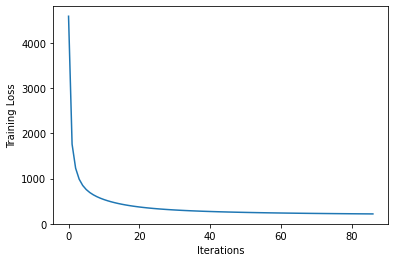

In [39]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel("Training Loss")

The subsequences embeddings are the trained weights of the model

In [40]:
vectors = (model.weight.weight.to('cpu').detach() + model.weight_tilde.weight.to('cpu').detach()).numpy()

In [41]:
kmers_vec = [vectorizer.vectorize(x) for x in preprocessed_seq]

The sequences embeddings are computed by the sum of the embeddings of their subsequences

In [42]:
data['kmers_enc'] = [np.sum(vectors[[y for y in x if y!=-1], :], axis=0) for x in kmers_vec]

In [43]:
gloveUtrs = np.vstack(data['kmers_enc'])

In [44]:
np.isfinite(gloveUtrs).all()

True

Read Fluorescence information and apply necessary transformations (negative values removal, log, cutoff at -20)

In [45]:
fDf = pd.read_csv('../processed_data/fluorescence_dataset.csv')
fDf.dropna(subset=['intensity'],inplace=True)
fDf.head()

,gene,systematicName,intensity
0,SSA1,YAL005C,11.906396
1,ERP2,YAL007C,0.299776
2,FUN14,YAL008W,0.455914
3,SPO7,YAL009W,0.027090
5,SWC3,YAL011W,0.031941


In [46]:
whole = data[['gene', 'kmers_enc']].merge(fDf[['gene','intensity']], on='gene', how='inner')
whole.head()

,gene,kmers_enc,intensity
0,SSA1,"[-11.063138, -7.55965, -1.6984223, 26.679756, ...",11.906396
1,ERP2,"[11.743881, -14.428677, -8.948473, 34.297478, ...",0.299776
2,FUN14,"[-4.4122405, -2.303894, 4.79992, 17.717606, 6....",0.455914
3,SPO7,"[4.501474, 3.4953349, 2.1645753, 18.373636, 5....",0.027090
4,SWC3,"[3.230321, 5.059218, 3.5185523, 19.376232, 3.3...",0.031941


In [47]:
i = whole['intensity'].copy()
mask = i > 0 # negative intensities make no sense
y = np.log(i[mask])
x = np.vstack(whole['kmers_enc'])[mask]

x = x[y>-20,:]
y = y[y>-20]

Text(0.5, 0, 'log(FI)')

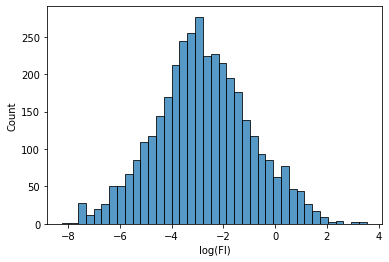

In [50]:
# QC of the transformed fluorescence values
sns.histplot(y)
plt.xlabel("log(FI)")

Analyze the relationship between embeddings and logFI

In [51]:
pcs = PCA(2).fit_transform(StandardScaler().fit_transform(x))

Text(0.5, 1.0, 'PCs of GLoVE embeddings')

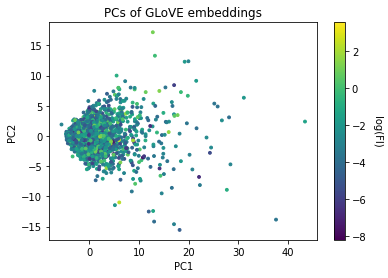

In [52]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=y, s=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(FI)', rotation=270)
plt.title("PCs of GLoVE embeddings")

In [56]:
## SelectKBest with f_regress 
featsSelector = SelectKBest(f_regression).fit(x,y)
qvals = multipletests(featsSelector.pvalues_, 0.1, method='fdr_bh')
print("Significant # of embedding dimensions:", sum(qvals[0]))

Significant # of embedding dimensions: 21


In [60]:
featsSelector.scores_[qvals[0]]

array([ 4.43448767,  4.47877453, 34.09796663,  9.11467351,  4.48910055,
        9.16628962, 22.45286734, 17.35697343, 29.14524616, 24.36572347,
       10.19466287, 18.03957146,  6.61134924,  5.79048327, 46.8839767 ,
        5.01484963, 45.66404935,  4.05982108, 41.88171621, 15.24354818,
       16.04434291])

In [63]:
lm = LinearRegression().fit(x[:, qvals[0]], y)
lm_preds = lm.predict(x[:, qvals[0]])
r2_score(y, lm_preds)

0.04525805029221053

In [65]:
print(np.sum((y - lm_preds)**2))

11801.453365626763


No linear discriminant power found

In [66]:
print("Total Variance")
print(np.sum((y - np.mean(y))**2))

Total Variance
12360.882822042902


In [67]:
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(x, y).predict(x)
print("Decision Tree MSE")
print(np.sum((tree_preds - y)**2))

Decision Tree MSE
6738.958713857732


In [68]:
preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(x,y).predict(x)

In [69]:
print("Random Forest MSE")
print(np.sum((preds - y)**2))

Random Forest MSE
1624.6708381902808


In [70]:
from sklearn.metrics.pairwise import cosine_similarity
xcos = cosine_similarity(x, x)

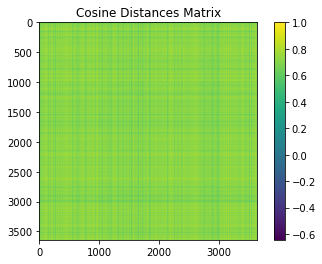

In [71]:
plt.imshow(xcos)
plt.title("Cosine Distances Matrix")
plt.colorbar()

In [72]:
# Cosine Distances -> StandardScaler -> PCA ->

cosPcs = PCA(300).fit_transform(StandardScaler().fit_transform(xcos))

Text(0.5, 1.0, 'PCs of GLoVE embeddings Cosine Distances')

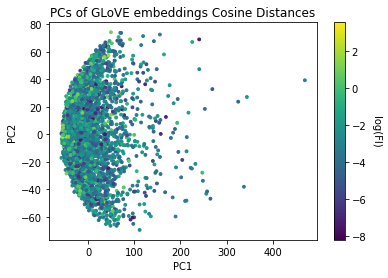

In [73]:
plt.scatter(cosPcs[:, 0], cosPcs[:, 1], c=y, s=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(FI)', rotation=270)
plt.title("PCs of GLoVE embeddings Cosine Distances")

In [74]:
# -> DT

In [75]:
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(pcs, y).predict(pcs)
# import graphviz 
# dot_data = tree.export_graphviz(treeRegressor, filled=True, out_file=None) 
# graph = graphviz.Source(dot_data)
# graph.render("gloveUtrsTree") 
print(np.sum((tree_preds - y)**2))

9096.135278900985


In [76]:
# -> RF
cos_preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(pcs,y).predict(pcs)

In [77]:
print("Random Forest on Cosine PCs MSE")
print(np.sum((cos_preds - y)**2))

Random Forest on Cosine PCs MSE
1928.3988949802633


In [78]:
# Checking Generalization Ability
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: -0.00415
Test data R-2 score: 0.0283
Test data Spearman correlation: 0.17
Test data Pearson correlation: 0.178


Text(0, 0.5, 'Train PR')

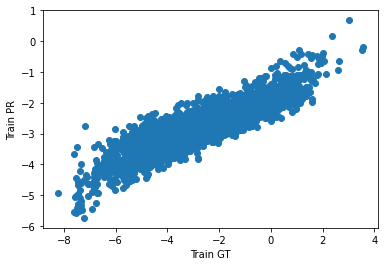

In [79]:
plt.scatter(y_train, predicted_train)
plt.xlabel("Train GT")
plt.ylabel("Train PR")

Text(0, 0.5, 'Test PR')

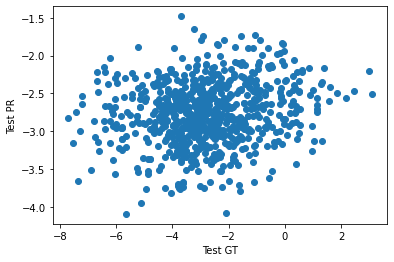

In [81]:
plt.scatter(y_test, predicted_test)
plt.xlabel("Test GT")
plt.ylabel("Test PR")

In [ ]:
import pickle
with open('../processed_data/utrs_glove_embeddings.pkl', 'wb') as out:
    pickle.dump({'data':np.vstack(data['kmers_enc']),'genes':data['gene']}, out)